# Kaggle Titanic Challenge

Here is a link to the dataset: https://www.kaggle.com/c/titanic.

## Goal
Apply machine learning to predict which passengers survived the Titanic sinking. 

**My goal is to submit a trained model and try to go up the leaderboard.** 

## Overview
**training set: train.csv**

*Shape*: (891, 12)

**testing set: test.csv**

*Shape*: (418, 11)

In [143]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import shuffle
from sklearn.preprocessing import scale
params = {
    'axes.labelsize': 'large',
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25,7]
}
plt.rcParams.update(params)

In [50]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [51]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [52]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Data Cleaning

First, I will impute the missing values. Then, proceed to pre-processing the data and feature engineering.

--- 

*Survived* is the label I want to predict. 0 means the passenger died, while 1 means they lived.

*PassengerId* will not be used in training, and so can be dropped.

### Imputing the Missing Values - Training

In [53]:
n_missing = train.isnull().sum().sort_values(ascending=False)
percent_missing = train.isnull().sum().sort_values(ascending=False) / len(train)
missing_train = pd.DataFrame(data=[n_missing, percent_missing])
missing_train

,Cabin,Age,Embarked,Fare,Ticket,Parch,SibSp,Sex,Name,Pclass,Survived,PassengerId
0,687.000000,177.000000,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.771044,0.198653,0.002245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


About 19% of the training data is missing *Age*. About 77% is missing *Cabin*, and 2 observations are missing *Embarked*.

#### Imputing Embarked

In [54]:
train[train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


Impute these two observations with the mode of Embarked. 

In [55]:
train.Embarked.fillna('C', inplace=True)

#### Imputing Cabin

Since ~77% of the features are missing, one may consider dropping it. But, having no data on *Cabin* can represent the passenger's low socio-economic status, which may be a factor towards their survival. As such, it is better to impute them.

The observations missing *Cabin* will be imputed with 'N'.
All others will be imputed with the first letter of the *Cabin* variable. 

In [56]:
train.Cabin.fillna('N', inplace=True)

In [57]:
train.Cabin.unique()

array(['N', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [58]:
train.Cabin = [i[0] for i in train.Cabin]

In [59]:
train.Cabin.value_counts()

N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64

#### Imputing Age

About 20% of the training observations are missing *Age*. To impute these, I will use Linear Regression to predict these missing values. 

However, this will be done once I engineer more features.

### Imputing the Missing Values - Testing

In [60]:
n_missing = test.isnull().sum().sort_values(ascending=False)
percent_missing = test.isnull().sum().sort_values(ascending=False) / len(train)
missing_test = pd.DataFrame(data=[n_missing, percent_missing])
missing_test

,Cabin,Age,Fare,Embarked,Ticket,Parch,SibSp,Sex,Name,Pclass,PassengerId
0,327.000000,86.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.367003,0.096521,0.001122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


86 of the testing data is missing *Age*. About 36% is missing *Cabin*, and 1 observation is missing *Fare*.

#### Imputing Fare

In [61]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


Impute this observation with the mean of passengers who are 'male', *Pclass* of '3', and *Embarked* from 'S'. 

In [62]:
miss_val = test.loc[(test.Sex == 'male') & (test.Pclass == 3) & (test.Embarked == 'S')].Fare.mean()
test.Fare.fillna(miss_val, inplace=True)

#### Imputing Cabin

Perform the same imputation done to the training set to be consistent.

In [63]:
test.Cabin.fillna('N', inplace=True)

In [64]:
test.Cabin.unique()

array(['N', 'B45', 'E31', 'B57 B59 B63 B66', 'B36', 'A21', 'C78', 'D34',
       'D19', 'A9', 'D15', 'C31', 'C23 C25 C27', 'F G63', 'B61', 'C53',
       'D43', 'C130', 'C132', 'C101', 'C55 C57', 'B71', 'C46', 'C116',
       'F', 'A29', 'G6', 'C6', 'C28', 'C51', 'E46', 'C54', 'C97', 'D22',
       'B10', 'F4', 'E45', 'E52', 'D30', 'B58 B60', 'E34', 'C62 C64',
       'A11', 'B11', 'C80', 'F33', 'C85', 'D37', 'C86', 'D21', 'C89',
       'F E46', 'A34', 'D', 'B26', 'C22 C26', 'B69', 'C32', 'B78',
       'F E57', 'F2', 'A18', 'C106', 'B51 B53 B55', 'D10 D12', 'E60',
       'E50', 'E39 E41', 'B52 B54 B56', 'C39', 'B24', 'D28', 'B41', 'C7',
       'D40', 'D38', 'C105'], dtype=object)

In [65]:
test.Cabin = [i[0] for i in test.Cabin]

In [66]:
test.Cabin.value_counts()

N    327
C     35
B     18
D     13
E      9
F      8
A      7
G      1
Name: Cabin, dtype: int64

In the training set, there is a *Cabin* with the label 'T'. When this is one-hot encoded, I will drop this column from the training set. Keeping it can cause some complications for training the model. 

If the model is trained on features that do not exist in the testing set, then the model can overfit the training set, and cannot generalize to new data. The model will have more variance and less bias.

#### Imputing Age

86 of the testing observations are missing *Age*. To impute these, I will use Linear Regression to predict these missing values. 

However, this will be done once I engineer more features.

### Feature Extraction

*Name* - Extract the title of each passenger. A passenger's title can have an effect on whether or not they survived. For instance, those with the title of *Master* may have been given priority to get on a life boat.

*SibSp* and *Parch* - Can create new features called *NumFamily*. So, for each passenger, the values of *SibSp* and *Parch* will be added + 1 (representing the passenger him/herself). 

*Ticket* - More analysis needs to be done for this feature. 

#### Extracting Title from Name

In [67]:
def get_title(i):
    title = i.split(', ')[1].split('.')[0]
    return title

In [68]:
train['Title'] = train.Name.apply(get_title)
test['Title'] = test.Name.apply(get_title)

In [69]:
title_dict = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Ms': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Dr',
    'Rev': 'Rev',
    'Col': 'Officer',
    'Mlle': 'Miss',
    'Major': 'Officer',
    'the Countess': 'Royal',
    'Sir': 'Royal',
    'Capt': 'Officer',
    'Don': 'Royal',
    'Mme': 'Royal',
    'Jonkheer': 'Royal',
    'Lady': 'Royal',
    'Dona': 'Royal'
}

train.Title = train.Title.map(title_dict)
train.drop('Name', axis=1, inplace=True)
test.Title = test.Title.map(title_dict)
test.drop('Name', axis=1, inplace=True)

In [70]:
train.Title.value_counts()

Mr         517
Miss       185
Mrs        125
Master      40
Dr           7
Royal        6
Rev          6
Officer      5
Name: Title, dtype: int64

In [71]:
test.Title.value_counts()

Mr         240
Miss        79
Mrs         72
Master      21
Rev          2
Officer      2
Royal        1
Dr           1
Name: Title, dtype: int64

#### Engineering NumFamily

In [72]:
train['NumFamily'] = train.SibSp + train.Parch + 1
test['NumFamily'] = test.SibSp + test.Parch + 1

#### Analyzing Ticket

In [73]:
train.Ticket.value_counts()

CA. 2343            7
347082              7
1601                7
3101295             6
CA 2144             6
347088              6
382652              5
S.O.C. 14879        5
349909              4
W./C. 6608          4
17421               4
PC 17757            4
19950               4
113760              4
LINE                4
113781              4
2666                4
4133                4
347077              4
C.A. 31921          3
35273               3
110413              3
248727              3
13502               3
F.C.C. 13529        3
SC/Paris 2123       3
230080              3
363291              3
29106               3
PC 17760            3
                   ..
382651              1
2680                1
349236              1
113788              1
230434              1
STON/O2. 3101282    1
35851               1
PC 17474            1
330979              1
234818              1
17464               1
383121              1
SC/AH Basle 541     1
36963               1
2641      

Looking at the unique values, there does not seem to be any reasonable way to distinguish/ clear up the data. There are lots of different levels for *Ticket*, and there is no clear way of pre-processing it. 

One may argue that *Ticket* can represent the socio-economic status of a passenger, which can influence survival. However, this can already be explained by the *Fare*, which is a much more interpretable way of determining the socio-economic status of a passenger.

So, I will drop *Ticket* from both datasets.

In [74]:
train.drop('Ticket', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)

### Pre-processing

*Pclass* - This is an integer, but is really describing is the social class the passenger belongs in (1st, 2nd, 3rd). One-Hot Encode for each social class level.

*Cabin*, *Embarked*, *Sex* - One-hot encode this. 

*Age* - Use Linear Regression to determine the missing *Age* values.

*PassengerId* - Drop this, since we won't need this in training. 

---

After imputing *Age*, drop *Cabin_T* from the training set. 

In [75]:
train.drop('PassengerId', axis=1, inplace=True)

In [76]:
train = pd.get_dummies(train, columns=['Title','Pclass','Embarked', 'Sex', 'Cabin'])
test = pd.get_dummies(test, columns=['Title','Pclass','Embarked', 'Sex', 'Cabin'])

In [77]:
train.drop('Cabin_T', axis=1, inplace=True)

#### Imputing Age Via Logistic Regression

In [78]:
def impute_age(df):
    temp_test = df.loc[df.Age.isnull()]
    temp_train = df.loc[df.Age.notna()]

    temp_train_X = temp_train.loc[:, 'SibSp':]
    temp_test_X = temp_test.loc[: , 'SibSp':]
    temp_train_y = temp_train.Age
    temp_test_y = temp_test.Age

    logreg = LinearRegression().fit(temp_train_X, temp_train_y)
    preds = logreg.predict(temp_test_X)

    df.loc[df.Age.isnull(), 'Age'] = preds

In [79]:
impute_age(train)
impute_age(test)

## Data Analysis

**After Feature Extraction and Pre-Processing...**

train - Shape: (891,31)

test - Shape: (418, 30)

### Heat-map of the correlation of Top 10 Features on Survived

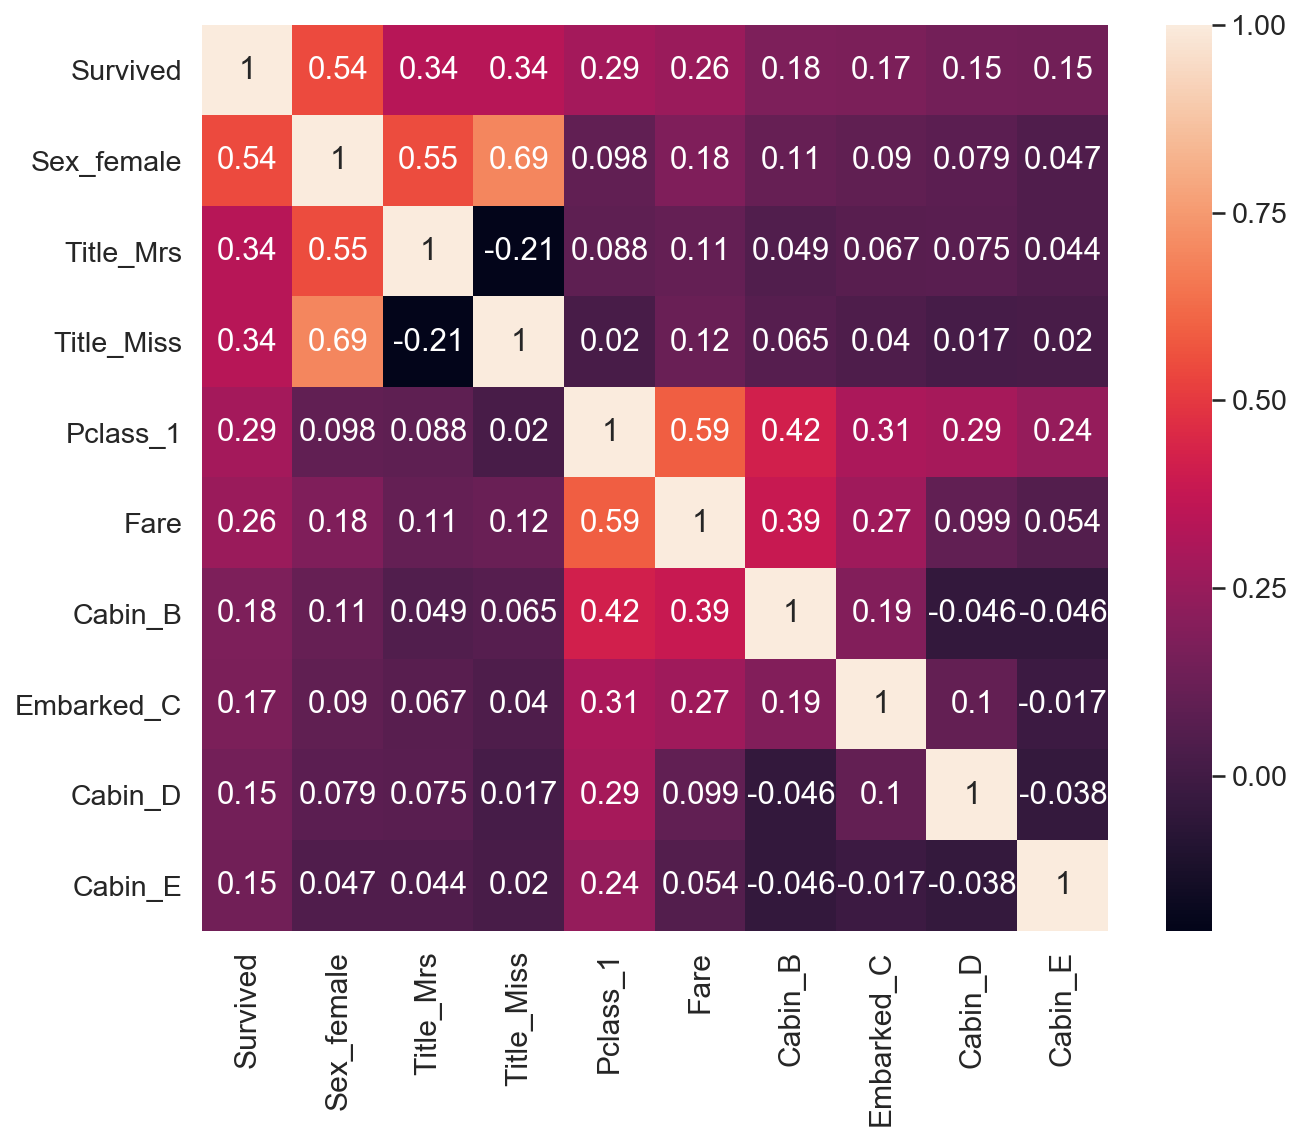

In [80]:
correlation_mat = train.corr(method='pearson')
corr_cols = correlation_mat.nlargest(10, 'Survived')['Survived'].index
correlation_mat = np.corrcoef(train[corr_cols].values.transpose())
f, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.25)
sns.heatmap(correlation_mat, square=True, annot=True, 
            yticklabels=corr_cols.values, xticklabels=corr_cols.values)
plt.show()

Being a female was correlated relatively strongly with survival, which is also shown in that *Title_Mrs* is also highly correlated with *Survival*.

### Distribution of Survival

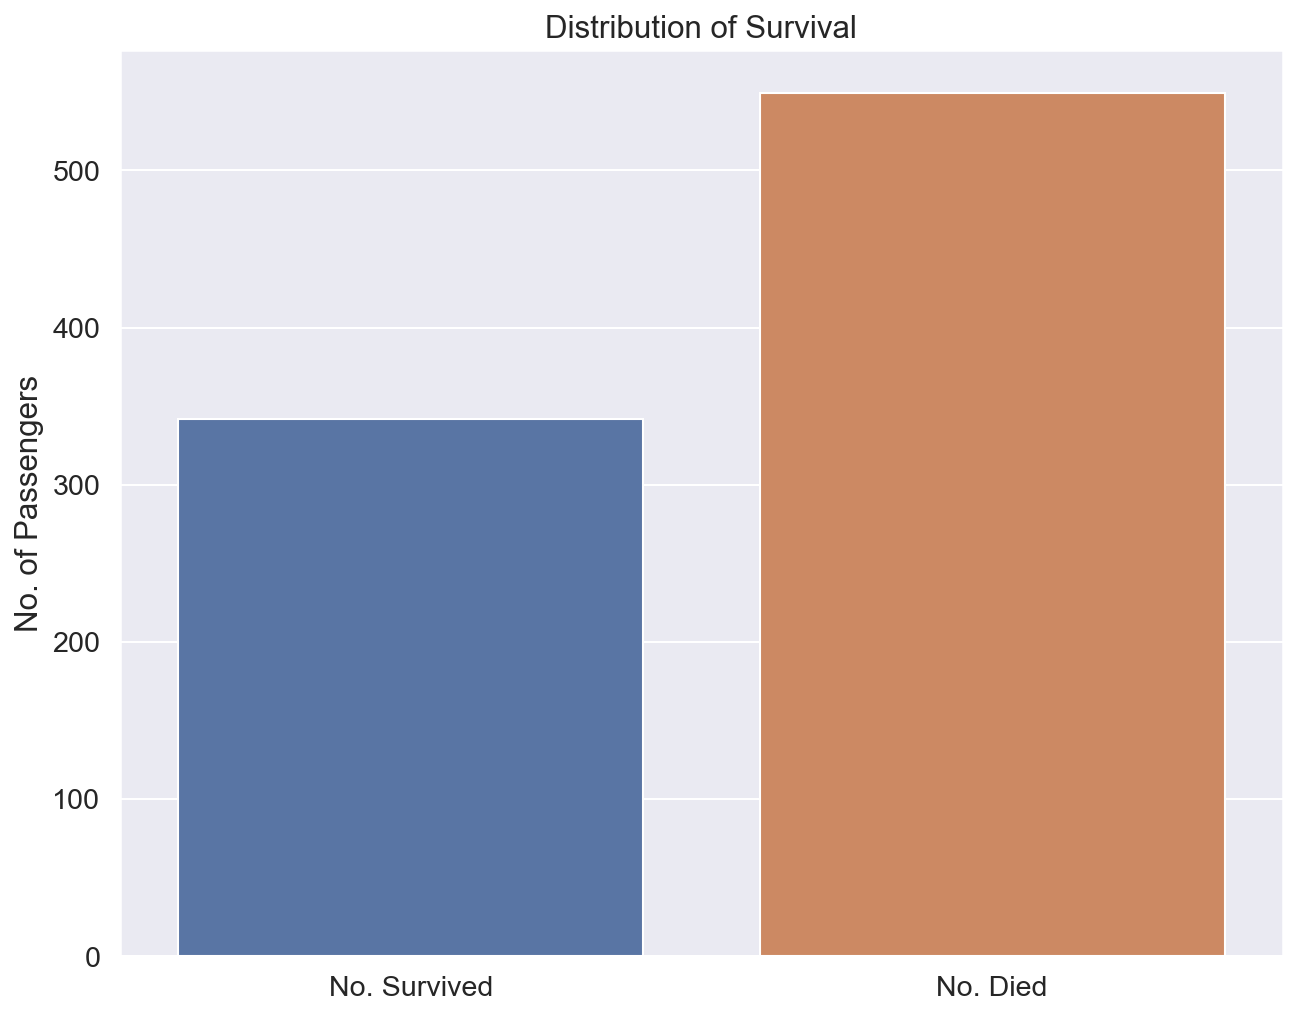

In [81]:
n_survived = len(train.loc[train["Survived"] == 1])
n_died = len(train) - n_survived

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['No. Survived', 'No. Died'], y=[n_survived, n_died]) 
plt.title('Distribution of Survival')
plt.ylabel('No. of Passengers')
plt.show()

Above, we see the distribution of all passengers that survived and died on the Titanic. As we can see, there are more casualties than survivors in the training set. This imbalance of classes would mean that, instead of using the accuracy as an error metric, it would be more appropriate to use another metric. 

I will use the F-Score as an error metric for training my models on this dataset.

### Distribution of Survival on Gender

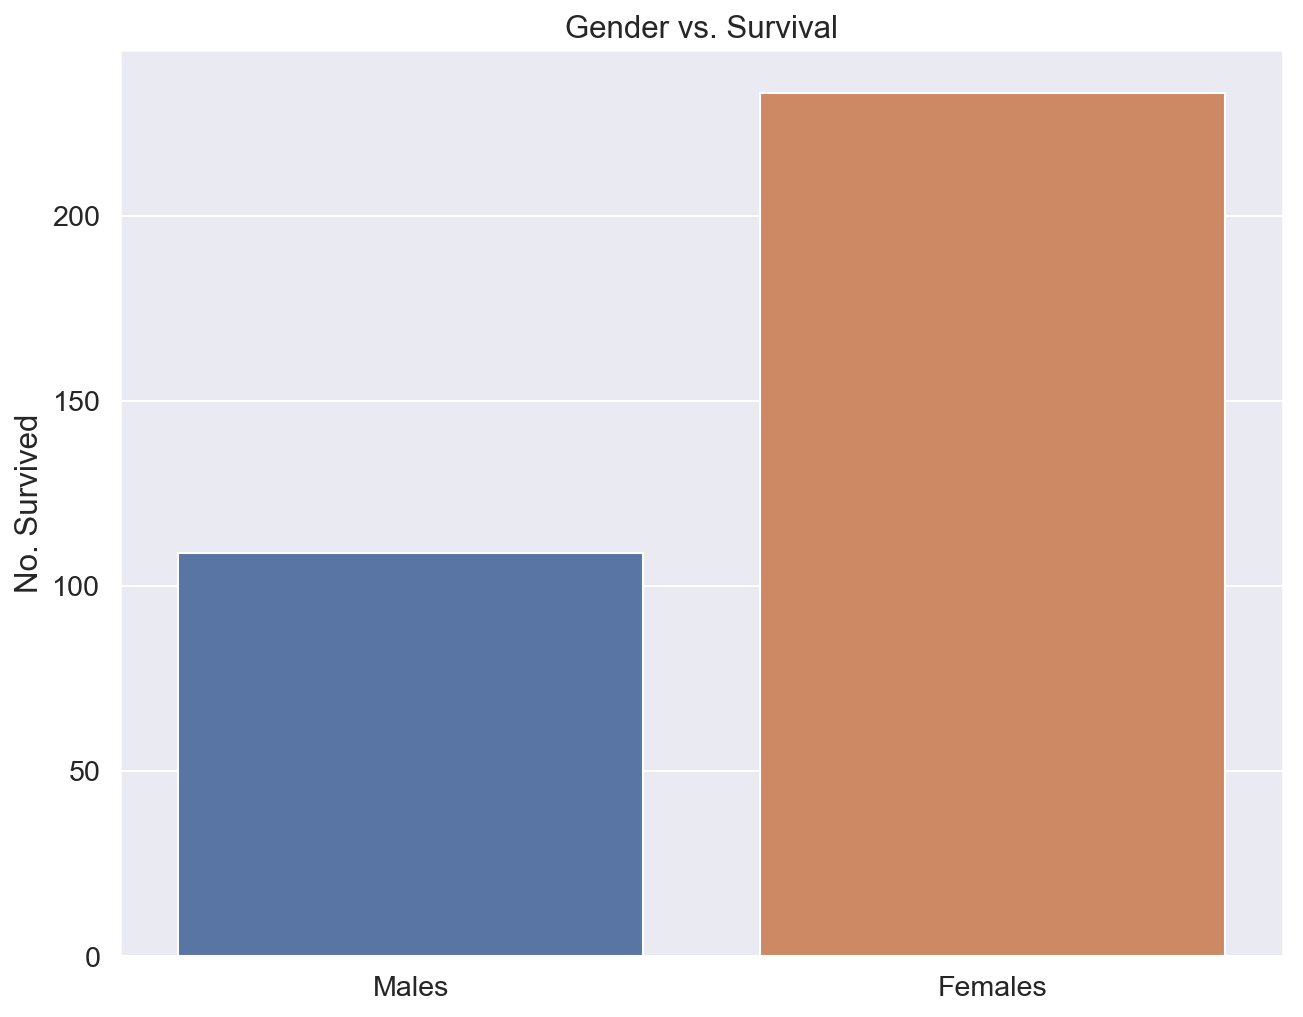

In [82]:
n_females_survived = train[(train['Sex_female'] == 1) & (train['Survived'] == 1)].Sex_female.sum()

n_males_survived = train[(train['Sex_male'] == 1) & (train['Survived'] == 1)].Sex_male.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['Males', 'Females'], y=[n_males_survived, n_females_survived]) 
plt.title('Gender vs. Survival')
plt.ylabel('No. Survived')
plt.show()

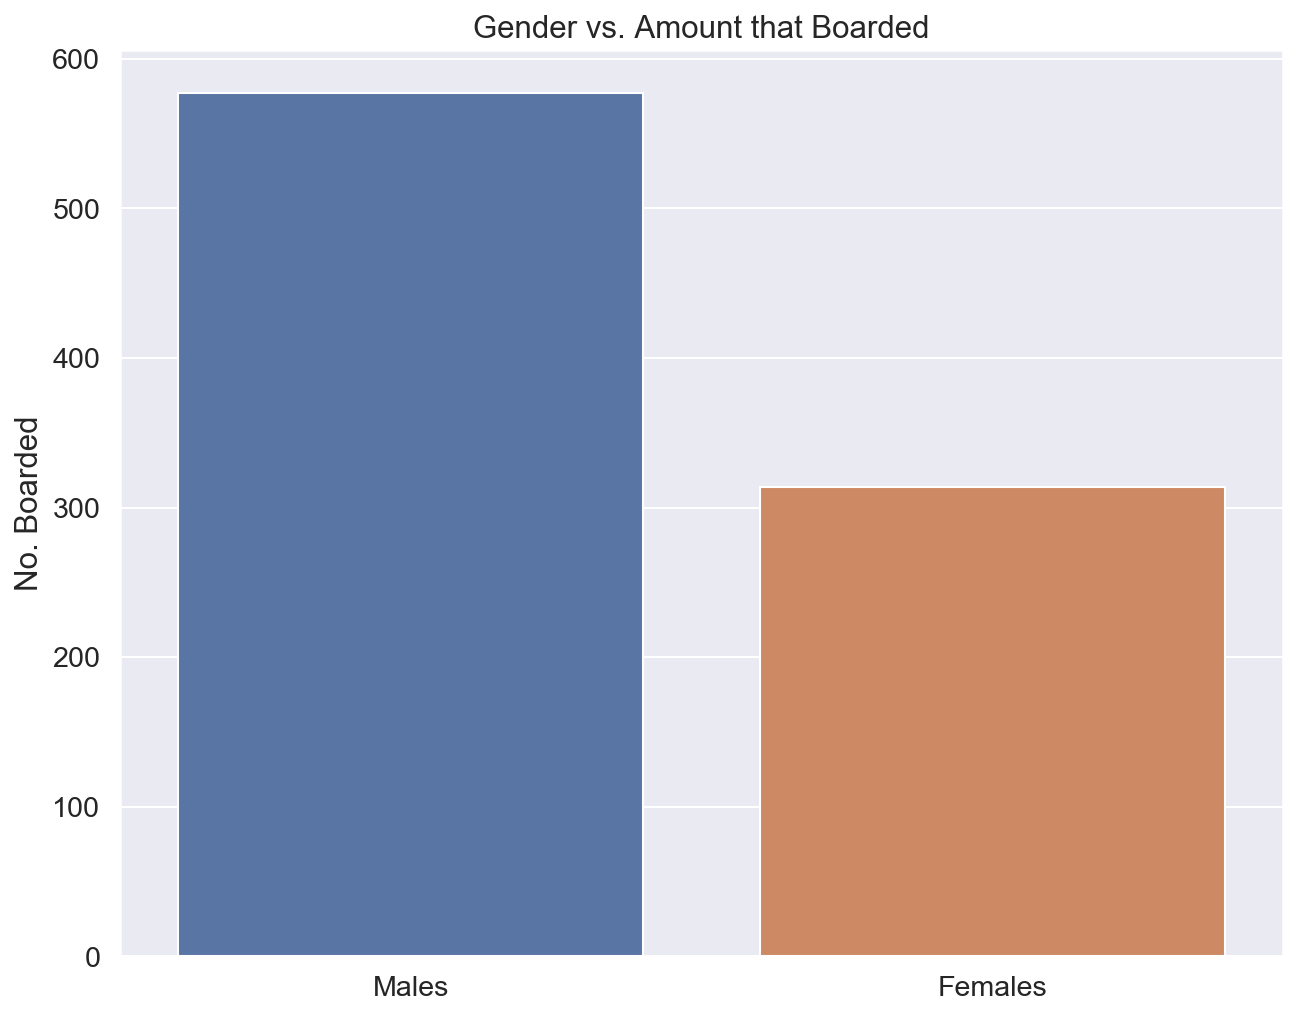

In [83]:
n_total_females = train[(train['Sex_female'] == 1)].Sex_female.sum()
n_total_males = train[(train['Sex_male'] == 1)].Sex_male.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['Males', 'Females'], y=[n_total_males, n_total_females]) 
plt.title('Gender vs. Amount that Boarded')
plt.ylabel('No. Boarded')
plt.show()

In [84]:
print('Proportion of Males that Survived: ', n_males_survived / n_total_males)
print('Proportion of Females that Survived: ', n_females_survived / n_total_females)

Proportion of Males that Survived:  0.18890814558058924
Proportion of Females that Survived:  0.7420382165605095


From the above plots, it would seem that women had a higher chance of surviving the Titanic disaster. Less woman boarded the ship initially, and were given more priority for boarding the lifeboats. 

Above, we can see the proportion of males and females that survived of all males and females, respectively. The proportion of females who survived is almost **4 times** than the proportion of males. 

### Distribution of Survival on Pclass

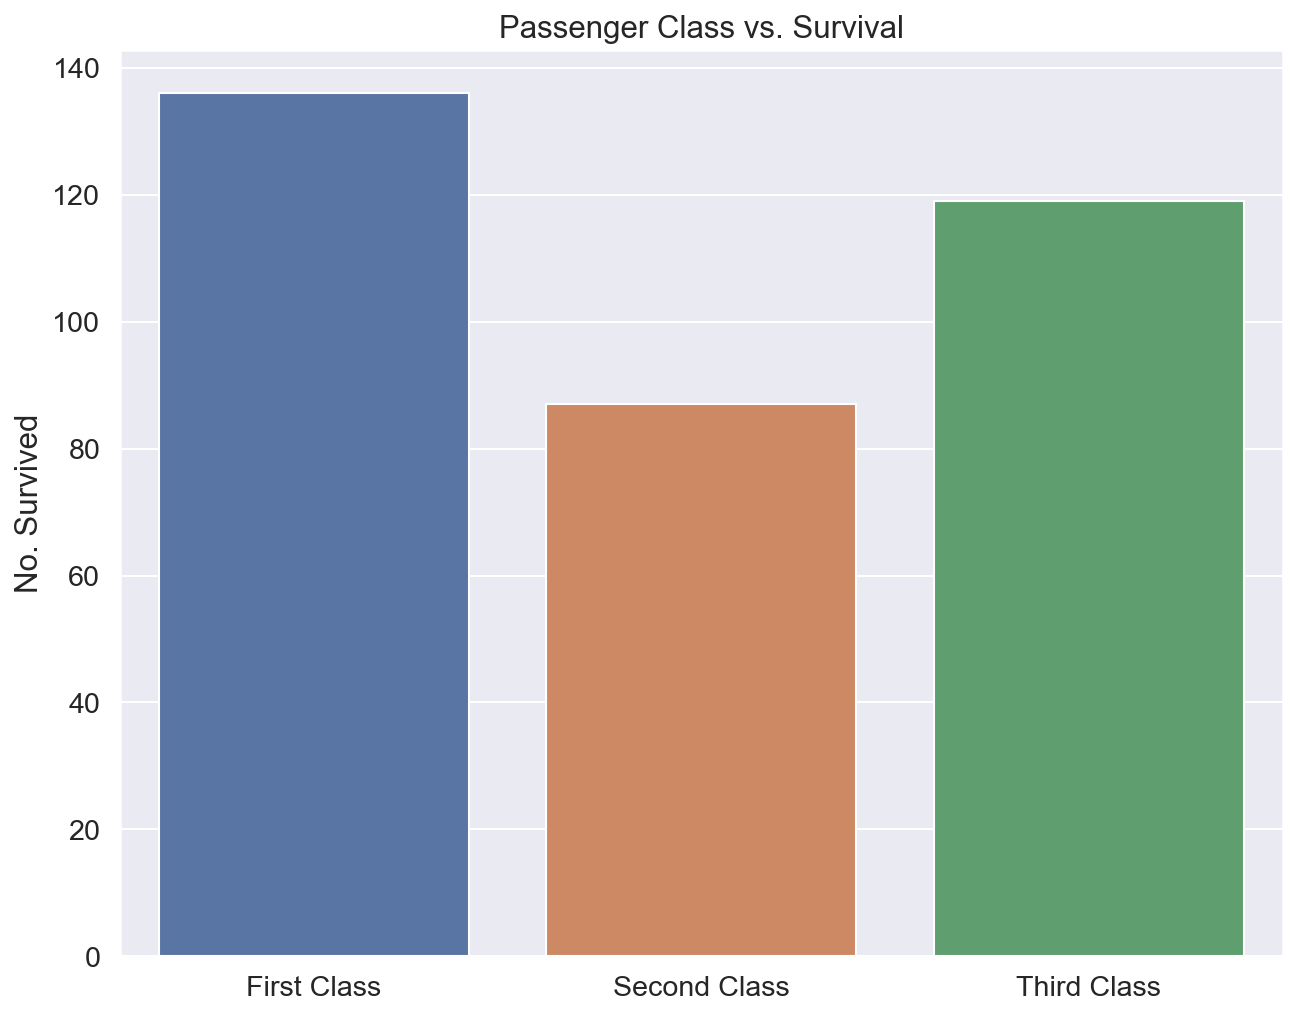

In [85]:
n_firstclass_survived = train[(train['Pclass_1'] == 1) & (train['Survived'] == 1)].Pclass_1.sum()
n_secondclass_survived = train[(train['Pclass_2'] == 1) & (train['Survived'] == 1)].Pclass_2.sum()
n_thirdclass_survived = train[(train['Pclass_3'] == 1) & (train['Survived'] == 1)].Pclass_3.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['First Class', 'Second Class', 'Third Class'], 
            y=[n_firstclass_survived, n_secondclass_survived, n_thirdclass_survived]) 
plt.title('Passenger Class vs. Survival')
plt.ylabel('No. Survived')
plt.show()

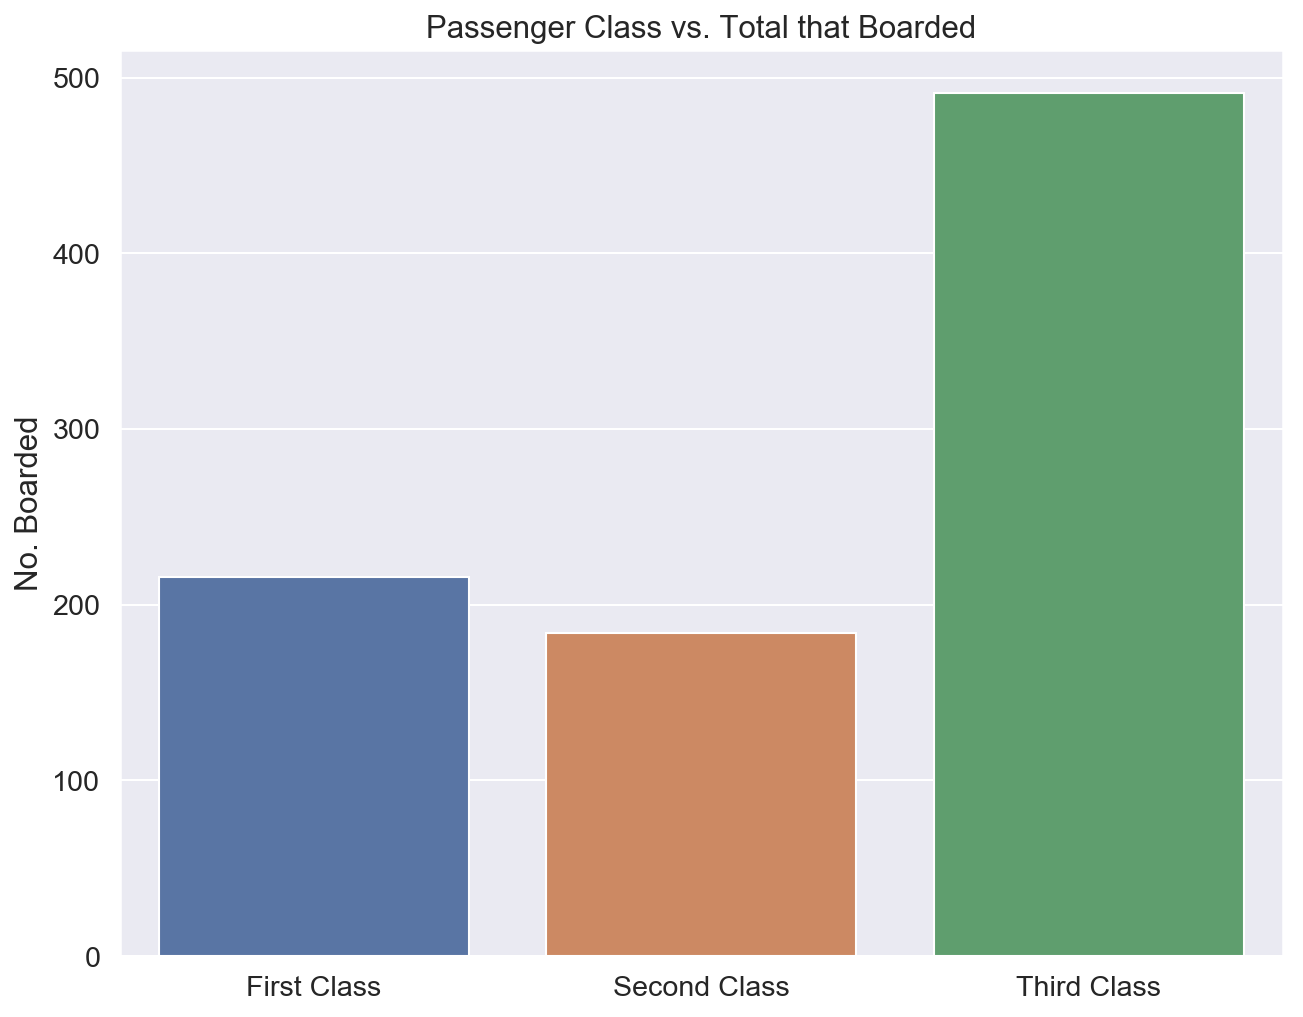

In [86]:
n_firstclass_total = train[(train['Pclass_1'] == 1)].Pclass_1.sum()
n_secondclass_total = train[(train['Pclass_2'] == 1)].Pclass_2.sum()
n_thirdclass_total = train[(train['Pclass_3'] == 1)].Pclass_3.sum()

f, ax = plt.subplots(figsize=(10,8))
sns.barplot(x=['First Class', 'Second Class', 'Third Class'], 
            y=[n_firstclass_total, n_secondclass_total, n_thirdclass_total]) 
plt.title('Passenger Class vs. Total that Boarded')
plt.ylabel('No. Boarded')
plt.show()

In [87]:
print('Proportion of First Class that Survived: ', n_firstclass_survived / n_firstclass_total)
print('Proportion of Second Class that Survived: ', n_secondclass_survived / n_secondclass_total)
print('Proportion of Third Class that Survived: ', n_thirdclass_survived / n_thirdclass_total)

Proportion of First Class that Survived:  0.6296296296296297
Proportion of Second Class that Survived:  0.47282608695652173
Proportion of Third Class that Survived:  0.24236252545824846


Above, we can see several bar charts showing the amount of each *Passenger* class that boarded, and how many of each class survived the disaster. 

Around 62% of all First Class passengers survived the Titanic sinking, which is almost **3 times** than that of Third Class passengers, where only about 24% of the all Third Class passengers survived. 

# Modeling

- **Logistic Regression**

Hyper-parameters: 

C = [0.05, 0.01, 0.5, 0.1, 1, 1.5, 2]

penalty = ['l1', 'l2']                

- **K-Nearest Neighbors**

Hyper-parameters: 

n_neighbors = [2...10]

- **Decision Tree Classifier**

Hyper-parameters:

criterion = ['entropy']

max_depth = [2...10]

min_samples_split = [2...10]

- **Support Vector Machine**

Hyper-parameters:

C_list = [0.01, 0.1, 1, 1.5, 2, 3]

- **AdaBoostClassifier**
- **Gaussian Naive Bayes**

After fitting the above, I will then use VotingClassifier, which is used for ensemble learning.

Error Metric: Accuracy

In [88]:
train.head(3)

,Survived,Age,SibSp,Parch,Fare,NumFamily,Title_Dr,Title_Master,Title_Miss,Title_Mr,...,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N
0,0,22.0,1,0,7.2500,2,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,1,38.0,1,0,71.2833,2,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1,26.0,0,0,7.9250,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


Looking at the above, *Age* and *Fare* are very different from the other quantitative variables. So, I will scale them by standardizing them. 

In [89]:
train.Age = scale(train.Age)
train.Fare = scale(train.Fare)

In [90]:
test.Age = scale(test.Age)
test.Fare = scale(test.Fare)

In [91]:
train.head(3)

,Survived,Age,SibSp,Parch,Fare,NumFamily,Title_Dr,Title_Master,Title_Miss,Title_Mr,...,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N
0,0,-0.562636,1,0,-0.502445,2,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
1,1,0.608746,1,0,0.786845,2,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1,-0.269791,0,0,-0.488854,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1


In [92]:
train = shuffle(train)
test = shuffle(test)

### Splitting Training Data

In [93]:
X = train.iloc[:, 1:]
y = train.Survived

In [94]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)

### Logistic Regression

In [144]:
C_list = [0.05, 0.01, 0.5, 0.1, 1, 1.5, 2]
logreg_params = {'C': C_list, 'penalty': ['l2']}

logreg = LogisticRegression(solver="lbfgs", max_iter = 200)

logreg_grid = GridSearchCV(logreg, logreg_params, cv=5, scoring='f1')
logreg_grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.05, 0.01, 0.5, 0.1, 1, 1.5, 2], 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [145]:
logreg_grid.best_score_

0.7651238254316035

In [146]:
logreg_grid.best_params_

{'C': 2, 'penalty': 'l2'}

In [147]:
logreg_star = logreg_grid.best_estimator_.fit(X_train_val, y_train_val)
f1 = f1_score(logreg_star.predict(X_test), y_test)

In [149]:
print('Logistic Regression F1 Score: ', f1)

Logistic Regression F1 Score:  0.8085106382978724


### K-Nearest Neighbors

In [150]:
n_neighbors_list=np.arange(1, 11, 1)
knn_params = {'n_neighbors': n_neighbors_list}

knn_grid = KNeighborsClassifier()

knn_grid = GridSearchCV(knn_grid, knn_params, cv=5, scoring='f1')
knn_grid.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [151]:
knn_grid.best_score_

0.7344379230305855

In [152]:
knn_grid.best_params_

{'n_neighbors': 3}

In [153]:
knn_star = knn_grid.best_estimator_.fit(X_train_val, y_train_val)
f1 = f1_score(knn_star.predict(X_test), y_test)

In [154]:
print('K-Nearest Neighbors F1 Score: ', f1)

K-Nearest Neighbors F1 Score:  0.7737226277372263


### Decision Tree Classifier

In [155]:
criterion_list = ['gini', 'entropy']
max_depth_list = np.arange(2, 11, 1)
min_samples_split_list = np.arange(2, 11, 1)

dt_params = {'criterion': criterion_list, 'max_depth': max_depth_list, 
             'min_samples_split': min_samples_split_list}

dt_grid = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt_grid, dt_params, cv=5, scoring='f1')

dt_grid.fit(X_train_val, y_train_val)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]), 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [156]:
dt_grid.best_score_

0.7519254853282004

In [157]:
dt_grid.best_params_

{'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 4}

In [158]:
dt_star = dt_grid.best_estimator_.fit(X_train_val, y_train_val)
f1 = f1_score(dt_star.predict(X_test), y_test)

In [159]:
print('Decision Tree Classifier F1 Score: ', f1)

Decision Tree Classifier F1 Score:  0.7448275862068966


### Bagging Classifer

In [ ]:
n_estimators_list = np.arange(30, 46, 1)
bdt_params = {'n_estimators': n_estimators_list,
              'base_estimator__criterion': criterion_list,
              'base_estimator__max_depth': max_depth_list,
              'base_estimator__min_samples_split': min_samples_split_list}

bc = BaggingClassifier(base_estimator = DecisionTreeClassifier(), 
                       oob_score = True, random_state = 420)
bc_grid = GridSearchCV(estimator = bc, cv=5, param_grid = bdt_params, scoring = 'f1')

bc_grid.fit(X_train_val, y_train_val)

In [ ]:
bc_grid.best_score_

In [ ]:
bc_grid.best_params_

In [ ]:
bc_star = bc_grid.best_estimator_.fit(X_train_val, y_train_val)
f1 = f1_score(bc_star.predict(X_test), y_test)

In [ ]:
print('Bagging Classifier F1 Score: ', f1)

### AdaBoostClassifier

In [ ]:
adaboost_clf = AdaBoostClassifier().fit(X_train_val, y_train_val)

In [ ]:
f1 = f1_score(adaboost_clf.predict(X_test), y_test)

In [ ]:
print('AdaBoostClassifier F1 Score: ', f1)

### Gaussian Naive Bayes

In [ ]:
val_f1s=[]
kfold = KFold(n_splits=5)

for train_i, val_i in kfold.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_i], X_train_val.iloc[val_i]
    y_train, y_val = y_train_val.iloc[train_i], y_train_val.iloc[val_i]
    
    gnb = GaussianNB().fit(X_train, y_train)
    
    val_f1s.append(f1_score(gnb.predict(X_val), y_val))

In [ ]:
gnb = GaussianNB().fit(X_train_val, y_train_val)
f1 = f1_score(gnb.predict(X_test), y_test)

print('GaussianNB F1 Score: ', f1)

### SVM

In [ ]:
C_list = [0.01, 0.1, 1, 1.5, 2, 3]
svc_params={'C': C_list}

svc = SVC(probability=True)

svc = GridSearchCV(svc, svc_params, cv=5, scoring='f1')
svc.fit(X_train_val, y_train_val)

In [ ]:
svc.best_score_

In [ ]:
svc.best_params_

In [ ]:
svc_star = svc.best_estimator_.fit(X_train_val, y_train_val)
f1 = f1_score(svc_star.predict(X_test), y_test)

In [ ]:
print('SVM F1 Score: ', f1)

### VotingClassifier

In [ ]:
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg_grid.best_estimator_),
        ('knn', knn_grid.best_estimator_),
        ('dt', dt_grid.best_estimator_),
        ('adaboost', AdaBoostClassifier()),
        ('gnb', GaussianNB()),
        ('svc', svc.best_estimator_)
    ], voting='soft').fit(X_train_val, y_train_val)

In [ ]:
f1 = f1_score(voting_clf.predict(X_test), y_test)
print('VotingClassifier Accuracy: ', f1)

# Submitting Test Predictions

In [121]:
passengerId = test.PassengerId
test.drop('PassengerId', axis=1, inplace=True)
submission = pd.DataFrame({
    'PassengerId': passengerId,
    'Survived': voting_clf.predict(test)
})

In [122]:
submission.to_csv('submissions.csv')